# EP-ABC: Simple example

## Setup

In [9]:
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## Toy Example

In [3]:
data = np.random.binomial(3, 0.3, size=5)

## MCMC-ABC

Try to find success probability $p$. Let $N = 5$ be fixed. Use mean and standard deviation as sufficient statistics. Use Euclidean norm as distance function. Use $p \sim \mathrm{Beta}(2, 2)$ as a prior. Use $N(p, \sigma^2)$ as transition kernel.

In [7]:
D = np.array([np.mean(data), np.std(data)])

In [23]:
D

array([0.6, 0.8])

Prior

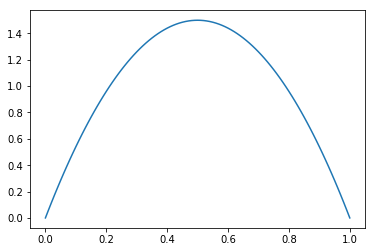

In [24]:
xs = np.arange(0, 1.01, 0.01)
ys = stats.beta(2, 2).pdf(xs)
plt.plot(xs, ys);

### Algorithm

Since $p \in [0, 1]$ it might be best to do inference on $\mathrm{logit}(p)$ or $\Phi^{-1}(p)$ to ensure that the parameter is unbounded.

In [ ]:
M = 1000    # Number of iterations
eps = 1e-1
ps = np.zeros((M + 1,), dtype='float64')

ps[0] = stats.beta(2, 2).rvs(1)

for m in range(M):
    pnew = ps[m] + 0.1 * np.randn()
    while pnew < 0 or pnew > 1:
        pnew = ps[m] + 0.1 * np.randn()
        
    data_sim = np.random.binomial(3, ps[m], size=5)
    Dsim = np.array([np.mean(data_sim), np.std(data_sim)])
    
    if np.linalg.norm(D - Dsim) <= eps:
        h = min(0, stats.beta(2, 2).logpdf(pnew) + )